Creating RawArray with float64 data, n_channels=5, n_times=3185966
    Range : 0 ... 3185965 =      0.000 ... 24890.352 secs
Ready.
<Info | 7 non-empty values
 bads: []
 ch_names: AF3, AF4, PZ, T7, T8
 chs: 5 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 5
 projs: []
 sfreq: 128.0 Hz
>
Using matplotlib as 2D backend.


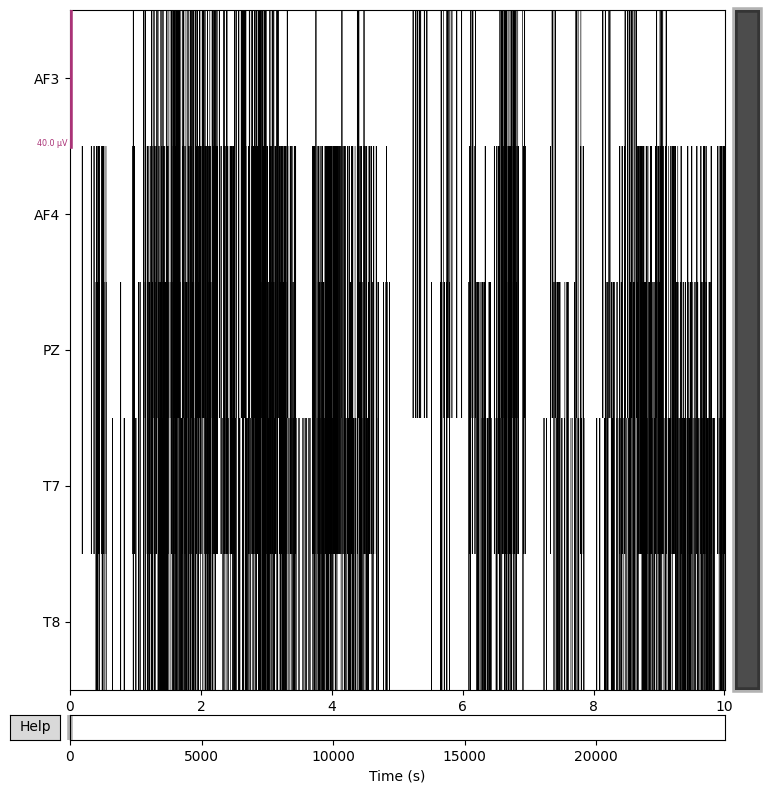

Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).


/var/folders/qr/lg0pblx11n77b0ktfk5n0qp00000gn/T/ipykernel_3169/2053366384.py:49: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd().plot()
/Users/zaaisvanzyl/Documents/GitHub/neural-interface-ml-pipeline/eeg_ml/lib/python3.9/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


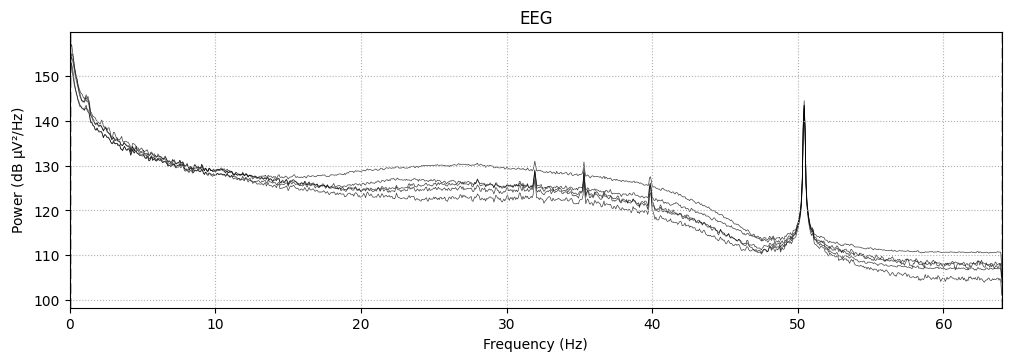

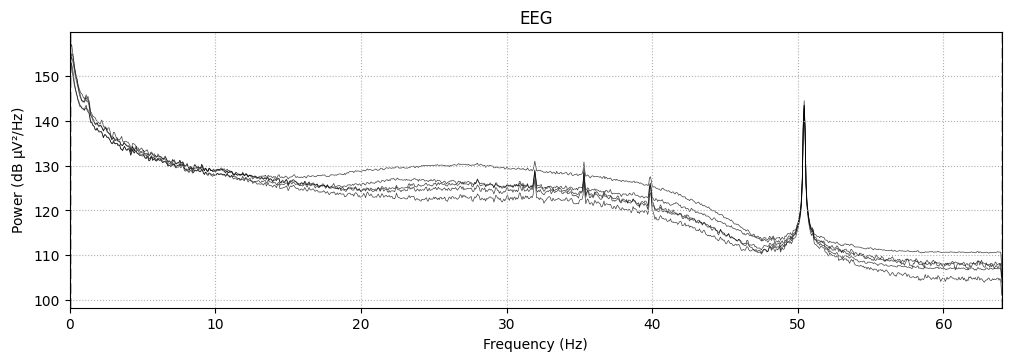

In [3]:
import mne
import numpy as np
import pandas as pd

def load_mindbigdata_txt(filepath):
    df = pd.read_csv(filepath, sep='\t', header=None,
                     names=['id', 'event_id', 'device', 'channel', 'code', 'size', 'data'])
    
    # Convert data strings to arrays
    df['data'] = df['data'].apply(lambda x: np.array([float(val) for val in x.split(',')]))
    
    # Get unique event_ids
    unique_events = df['event_id'].unique()
    
    # Get parameters from first trial
    sfreq = df['size'].iloc[0] / 2  # Size represents 2 seconds of data
    ch_names = sorted(df['channel'].unique())  # Get unique channel names
    
    # Reshape data into (n_channels, n_timepoints * n_trials)
    all_data = []
    for ch in ch_names:
        ch_data = np.concatenate(df[df['channel'] == ch]['data'].values)
        all_data.append(ch_data)
    data = np.array(all_data)
    
    # Create info object
    info = mne.create_info(
        ch_names=ch_names,
        sfreq=sfreq,
        ch_types=['eeg'] * len(ch_names)
    )
    
    # Create Raw object
    raw = mne.io.RawArray(data, info)
    
    # Create events array
    events = np.zeros((len(unique_events), 3), dtype=int)
    events[:, 0] = np.arange(0, len(unique_events) * 256, 256)  # Sample indices
    events[:, 2] = df.groupby('event_id')['code'].first().values  # Event codes
    
    return raw, events, data, df

raw, events, data, df = load_mindbigdata_txt('../data/MindBigData-IN-v1.06.txt')

print(raw.info)

raw.plot()

raw.compute_psd().plot()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (6.602 s)



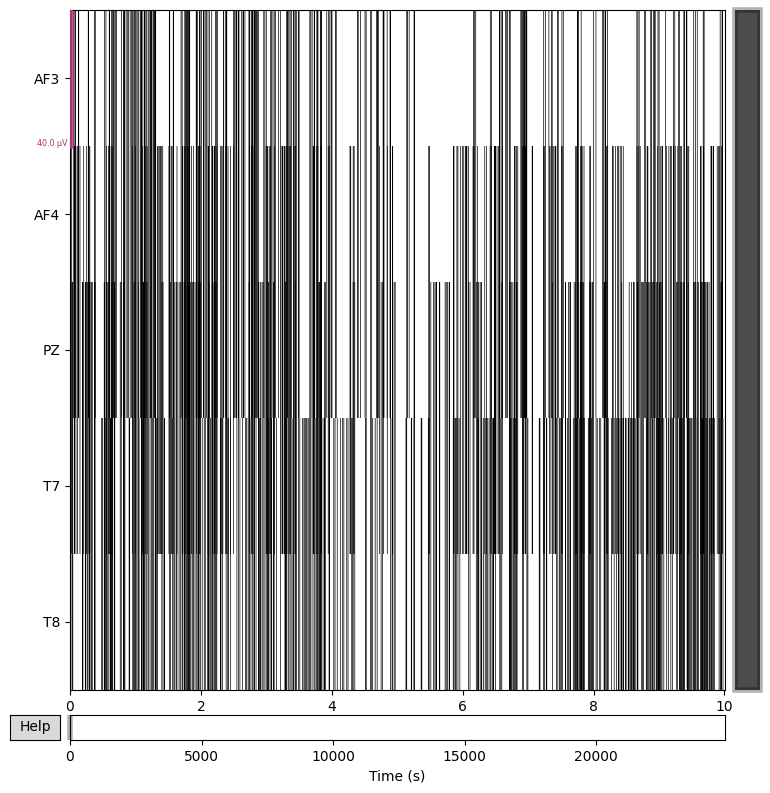

Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).


/var/folders/qr/lg0pblx11n77b0ktfk5n0qp00000gn/T/ipykernel_3169/4188184818.py:4: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd().plot()
/Users/zaaisvanzyl/Documents/GitHub/neural-interface-ml-pipeline/eeg_ml/lib/python3.9/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


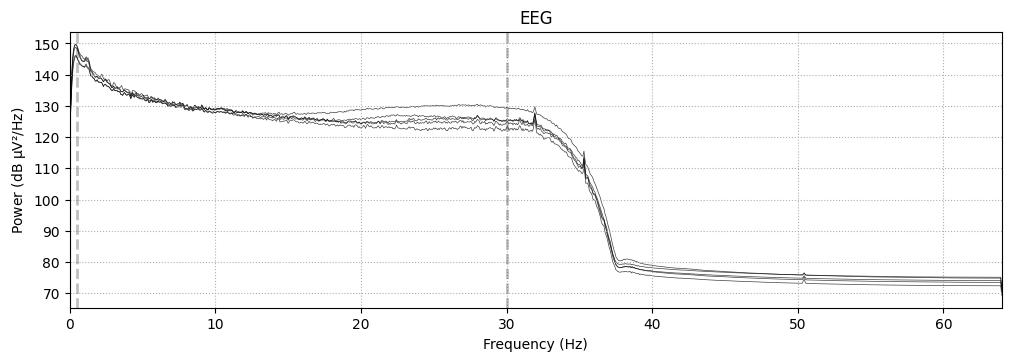

In [4]:
raw = raw.copy().filter(l_freq=0.5, h_freq=30, fir_design='firwin')
raw.plot()

raw.compute_psd().plot()

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)



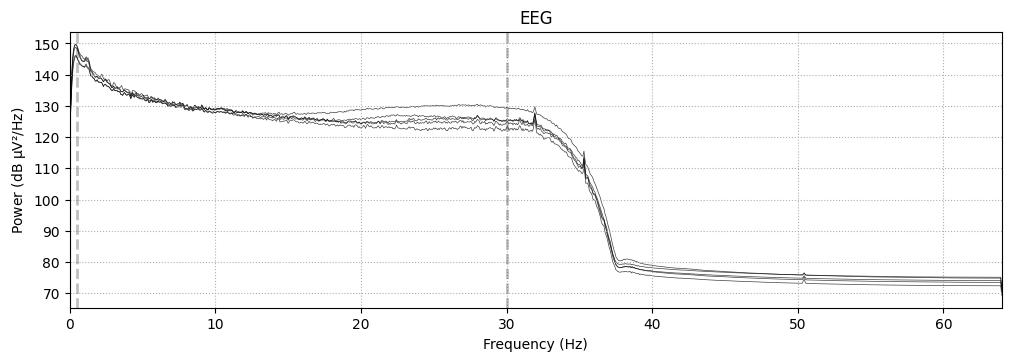

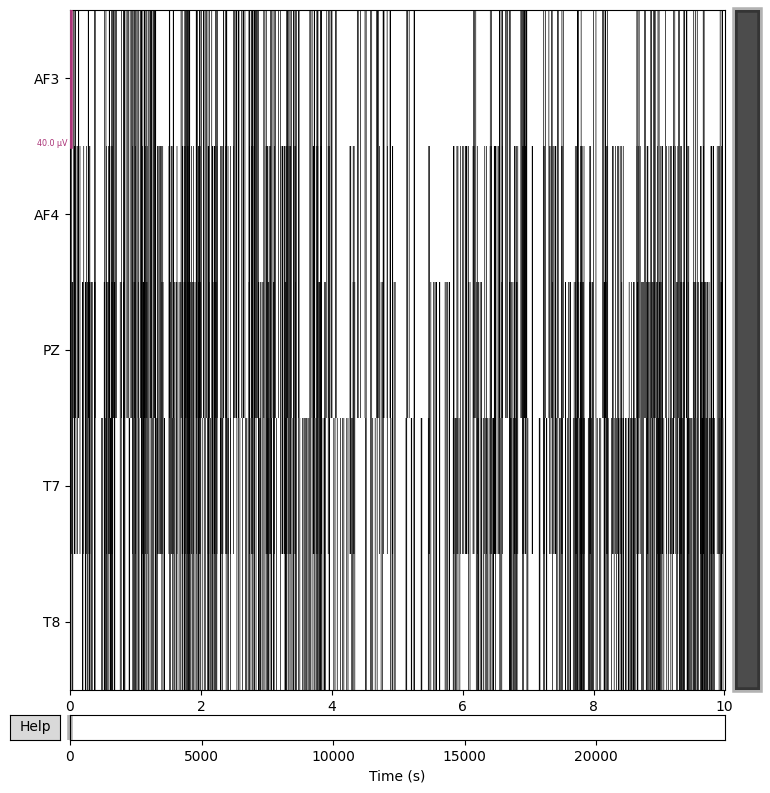

Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).


/var/folders/qr/lg0pblx11n77b0ktfk5n0qp00000gn/T/ipykernel_3169/154686354.py:5: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd().plot()
/Users/zaaisvanzyl/Documents/GitHub/neural-interface-ml-pipeline/eeg_ml/lib/python3.9/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


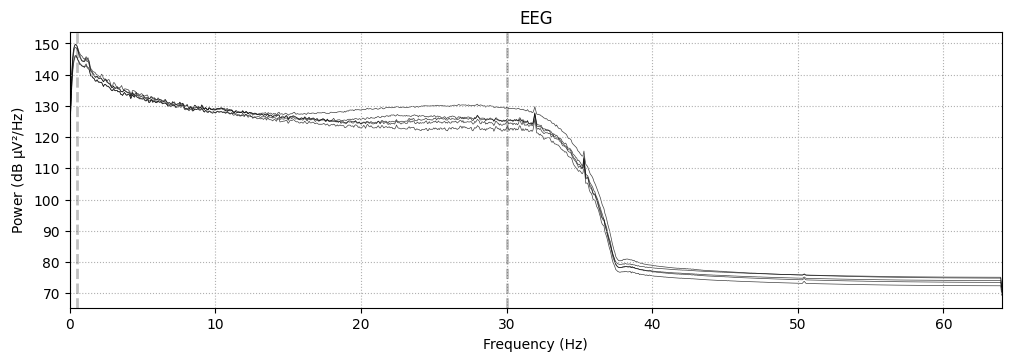

In [5]:
raw = raw.copy().notch_filter(freqs=50.0, fir_design='firwin')

raw.plot()

raw.compute_psd().plot()

In [6]:
# raw.info['bads'] = []
# raw.info['bads'] += mne.preprocessing.find_bad_channels_maxwell(raw, h_freq=30)

# raw = raw.copy().interpolate_bads(reset_bads=True)

# raw.plot()

# raw.compute_psd().plot()

In [7]:
# ica = mne.preprocessing.ICA(n_components=5, method='fastica', random_state=42)
# ica.fit(raw)

# eog_indices, eog_scores = ica.find_bads_eog(raw, measure='correlation')

# ica.exclude = eog_indices

# raw_clean = ica.apply(raw.copy())

In [8]:
raw = raw.copy().set_eeg_reference('average', projection=True)

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


In [9]:
n_samples = len(df)
events = np.zeros((n_samples, 3), dtype=int)
events[:, 0] = np.arange(n_samples)
events[:, 2] = df['code'].values

event_id = {f'digit_{i}': i for i in range(10)}

epochs = mne.Epochs(raw, events, event_id=event_id, 
                   tmin=-0.2, tmax=0.8,
                   baseline=(None, 0), preload=True)

print("Shape of raw data:", raw.get_data().shape)
print("Number of samples in df:", len(df))
print("Shape of events array:", events.shape)

Not setting metadata
65250 matching events found
Setting baseline interval to [-0.203125, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 65250 events and 129 original time points ...
26 bad epochs dropped
Shape of raw data: (5, 3185966)
Number of samples in df: 65250
Shape of events array: (65250, 3)


In [10]:
epochs = epochs.copy().apply_baseline(baseline=(None, 0))


Applying baseline correction (mode: mean)


In [11]:
data = epochs.get_data()
mean = data.mean(axis=2, keepdims=True)
std = data.std(axis=2, keepdims=True)
data_normalized = (data - mean) / std
epochs_normalized = mne.EpochsArray(data_normalized, info=epochs.info, events=epochs.events, event_id=epochs.event_id)

Not setting metadata
65224 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


In [12]:
from mne.decoding import CSP
import numpy as np
from sklearn.preprocessing import StandardScaler

# Get the data
data = epochs.get_data()

# Reshape for scaling (combine trials and time points)
orig_shape = data.shape
data_2d = data.reshape(orig_shape[0], -1)

# Scale the data
scaler = StandardScaler()
data_2d_scaled = scaler.fit_transform(data_2d)

# Reshape back
data_scaled = data_2d_scaled.reshape(orig_shape)

# Verify data is clean
print("\nAfter scaling:")
print("NaN count:", np.isnan(data_scaled).sum())
print("Inf count:", np.isinf(data_scaled).sum())
print("Min value:", np.min(data_scaled))
print("Max value:", np.max(data_scaled))

# Apply CSP
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
csp.fit(data_scaled, epochs.events[:, -1])
features = csp.transform(data_scaled)


After scaling:
NaN count: 0
Inf count: 0
Min value: -63.4077449417717
Max value: 70.6179057315283
Computing rank from data with rank=None
    Using tolerance 4.3 (2.2e-16 eps * 5 dim * 3.9e+15  max singular value)
    Estimated rank (data): 5
    data: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=2 covariance using EMPIRICAL
Done.
Estimating class=3 covariance using EMPIRICAL
Done.
Estimating class=4 covariance using EMPIRICAL
Done.
Estimating class=5 covariance using EMPIRICAL
Done.
Estimating class=6 covariance using EMPIRICAL
Done.
Estimating class=7 covariance using EMPIRICAL
Done.
Estimating class=8 covariance using EMPIRICAL
Done.
Estimating class=9 covariance using EMPIRICAL
Done.


In [13]:
noise_level = 0.01
noise = np.random.normal(0, noise_level, features.shape)
features_augmented = features + noise

In [14]:
shift_seconds = 0.05
sfreq = raw.info['sfreq']
shift_samples = int(shift_seconds * sfreq)
data = epochs.get_data()
data_shifted = np.roll(data, shift_samples, axis=2)
epochs = mne.EpochsArray(data_shifted, info=epochs.info, events=epochs.events, event_id=epochs.event_id)

Not setting metadata
65224 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


In [15]:
## Define labels for CSP
labels = epochs.events[:, 2]

In [16]:
features_final = np.vstack((features, features_augmented))
labels_final = np.hstack((labels, labels))

print(f"Features shape: {features_final.shape}")
print(f"Labels shape: {labels_final.shape}")

Features shape: (130448, 4)
Labels shape: (130448,)


In [25]:
import tensorflow as tf
from keras import layers, models

def EEGNet(nb_classes, Chans, Samples, dropoutRate=0.5, kernLength=2, F1=8, D=2, F2=16, dropoutType='Dropout'):
    if dropoutType == 'SpatialDropout2D':
        drop = layers.SpatialDropout2D
    else:
        drop = layers.Dropout

    input1 = layers.Input(shape=(Chans, Samples, 1))

    # Reduced kernel size and removed pooling operations
    block1 = layers.Conv2D(F1, (1, kernLength), padding='same',
                          input_shape=(Chans, Samples, 1),
                          use_bias=False)(input1)
    block1 = layers.BatchNormalization(axis=3)(block1)
    block1 = layers.DepthwiseConv2D((Chans, 1), use_bias=False,
                                    depth_multiplier=D,
                                    depthwise_constraint=tf.keras.constraints.MaxNorm(1.))(block1)
    block1 = layers.BatchNormalization(axis=3)(block1)
    block1 = layers.Activation('elu')(block1)
    block1 = drop(dropoutRate)(block1)

    block2 = layers.SeparableConv2D(F2, (1, 1),  # Reduced kernel size
                                    use_bias=False, padding='same')(block1)
    block2 = layers.BatchNormalization(axis=3)(block2)
    block2 = layers.Activation('elu')(block2)
    block2 = drop(dropoutRate)(block2)

    # Remove AveragePooling2D and just use Flatten
    flatten = layers.Flatten()(block2)
    flatten = layers.Dropout(dropoutRate)(flatten)

    dense = layers.Dense(nb_classes, name='dense',
                         kernel_constraint=tf.keras.constraints.MaxNorm(0.25))(flatten)
    softmax = layers.Activation('softmax', name='softmax')(dense)

    return models.Model(inputs=input1, outputs=softmax)

In [28]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

encoded_labels = labels_final
eeg_data = features_final

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    eeg_data, labels_final, test_size=0.2, random_state=42
)

# Reshape for EEGNet (add channel dimension)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [34]:
X = epochs.get_data()
print("Label distribution:", np.bincount(labels))  # Should be roughly even
print("Data shape:", X.shape)
print("Data stats:", {
    "mean": np.mean(X),
    "std": np.std(X),
    "min": np.min(X),
    "max": np.max(X),
    "nan_count": np.isnan(X).sum(),
    "inf_count": np.isinf(X).sum()
})

Label distribution: [6300 6740 6535 6605 6610 6460 6419 6470 6585 6500]
Data shape: (65224, 5, 129)
Data stats: {'mean': np.float64(-5.945189790497893e-20), 'std': np.float64(18.102531029410383), 'min': np.float64(-1097.867970476896), 'max': np.float64(951.971325996746), 'nan_count': np.int64(0), 'inf_count': np.int64(0)}


Epoch 1/100
816/816 ━━━━━━━━━━━━━━━━━━━━ 42s 50ms/step - accuracy: 0.1099 - loss: 2.6412 - val_accuracy: 0.1611 - val_loss: 2.2627 - learning_rate: 0.0010
Epoch 2/100
816/816 ━━━━━━━━━━━━━━━━━━━━ 39s 48ms/step - accuracy: 0.1438 - loss: 2.2870 - val_accuracy: 0.1875 - val_loss: 2.2343 - learning_rate: 0.0010
Epoch 3/100
816/816 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - accuracy: 0.1724 - loss: 2.2361 - val_accuracy: 0.2242 - val_loss: 2.1822 - learning_rate: 0.0010
Epoch 4/100
816/816 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - accuracy: 0.2039 - loss: 2.1814 - val_accuracy: 0.2676 - val_loss: 2.1025 - learning_rate: 0.0010
Epoch 5/100
816/816 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - accuracy: 0.2468 - loss: 2.1010 - val_accuracy: 0.3425 - val_loss: 1.9926 - learning_rate: 0.0010
Epoch 6/100
816/816 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - accuracy: 0.2971 - loss: 1.9955 - val_accuracy: 0.3959 - val_loss: 1.8575 - learning_rate: 0.0010
Epoch 7/100
816/816 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - accuracy: 0.3

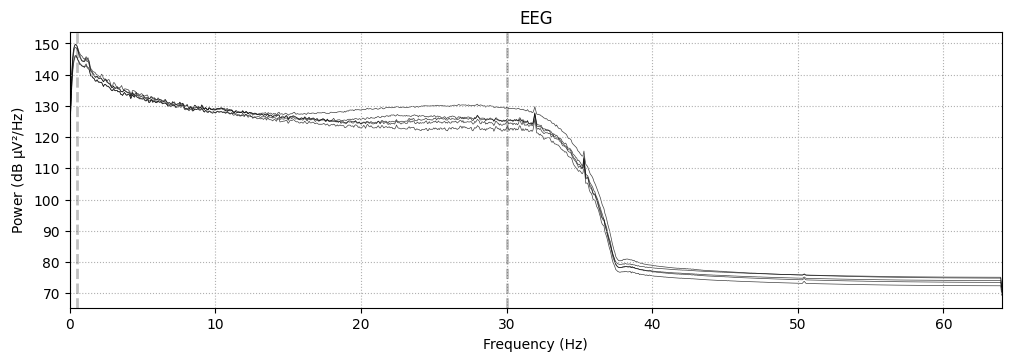

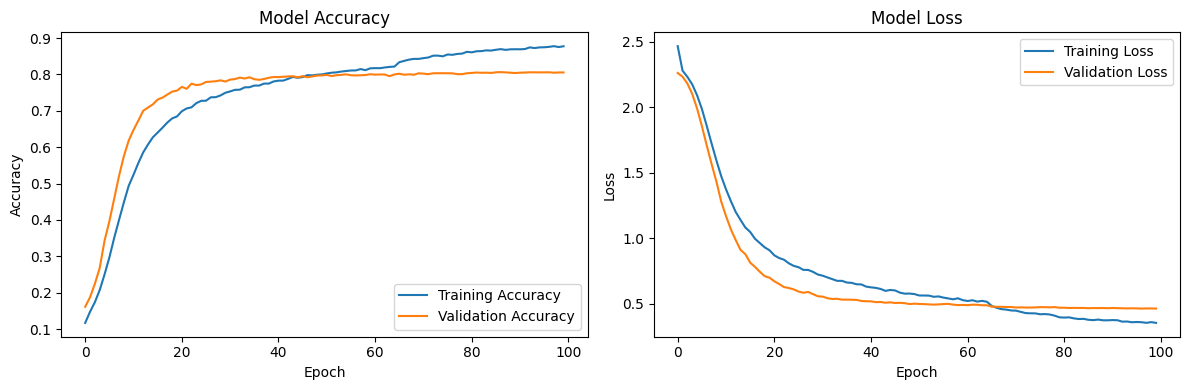

In [36]:
# Simple CNN for EEG classification
def SimpleCNN(nb_classes, Chans=5, Samples=129):
    input_layer = layers.Input(shape=(Chans, Samples, 1))
    
    # First Convolutional Block
    conv1 = layers.Conv2D(32, (3, 3), padding='same')(input_layer)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.ReLU()(conv1)
    conv1 = layers.MaxPooling2D((1, 2))(conv1)
    conv1 = layers.Dropout(0.3)(conv1)
    
    # Second Convolutional Block
    conv2 = layers.Conv2D(64, (3, 3), padding='same')(conv1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.ReLU()(conv2)
    conv2 = layers.MaxPooling2D((1, 2))(conv2)
    conv2 = layers.Dropout(0.3)(conv2)
    
    # Third Convolutional Block
    conv3 = layers.Conv2D(128, (3, 3), padding='same')(conv2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.ReLU()(conv3)
    conv3 = layers.MaxPooling2D((1, 2))(conv3)
    conv3 = layers.Dropout(0.3)(conv3)
    
    # Dense Layers
    flatten = layers.Flatten()(conv3)
    dense1 = layers.Dense(256)(flatten)
    dense1 = layers.BatchNormalization()(dense1)
    dense1 = layers.ReLU()(dense1)
    dense1 = layers.Dropout(0.5)(dense1)
    
    output = layers.Dense(nb_classes, activation='softmax')(dense1)
    
    model = models.Model(inputs=input_layer, outputs=output)
    return model

# Create and compile model
cnn_model = SimpleCNN(nb_classes=10)

# Compile with the same parameters
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
cnn_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history_cnn = cnn_model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=20,
            restore_best_weights=True,
            mode='max'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.5,
            patience=5,
            min_lr=0.00001,
            mode='max'
        )
    ],
    verbose=1
)

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


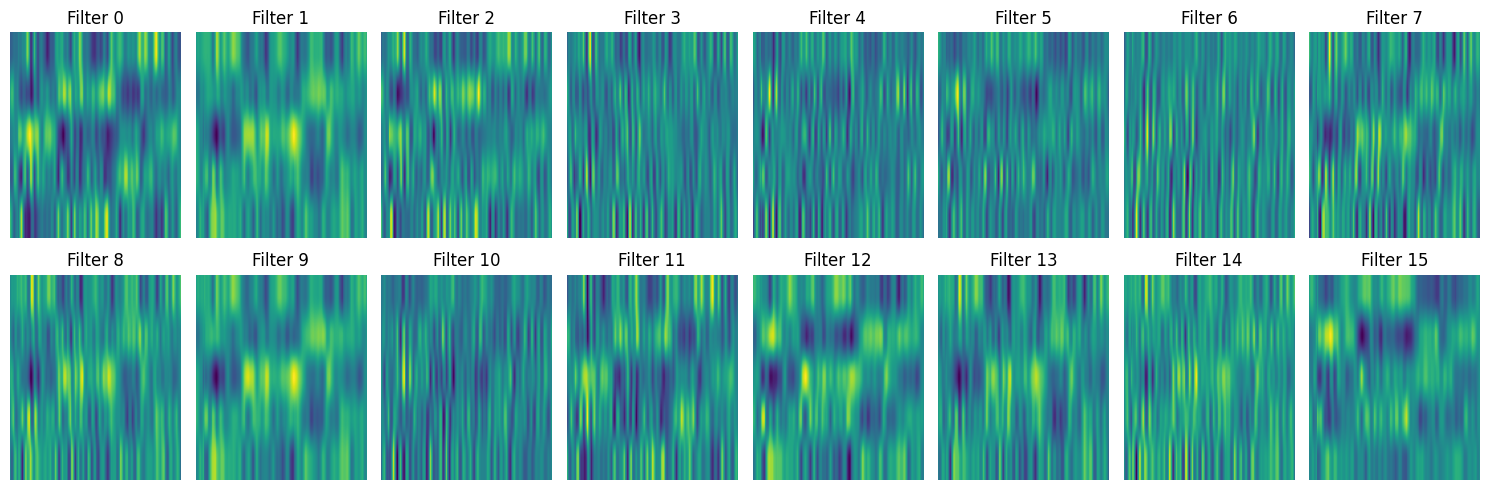

In [38]:
layer_name = 'conv2d_11'
intermediate_model = tf.keras.Model(inputs=cnn_model.input,
                                  outputs=cnn_model.get_layer(layer_name).output)

sample_idx = 0
activations = intermediate_model.predict(X_test[sample_idx:sample_idx+1])

# Plot activations
plt.figure(figsize=(15, 5))
for i in range(min(16, activations.shape[-1])):
    plt.subplot(2, 8, i+1)
    plt.imshow(activations[0, :, :, i], aspect='auto')
    plt.title(f'Filter {i}')
    plt.axis('off')
plt.tight_layout()
plt.show()

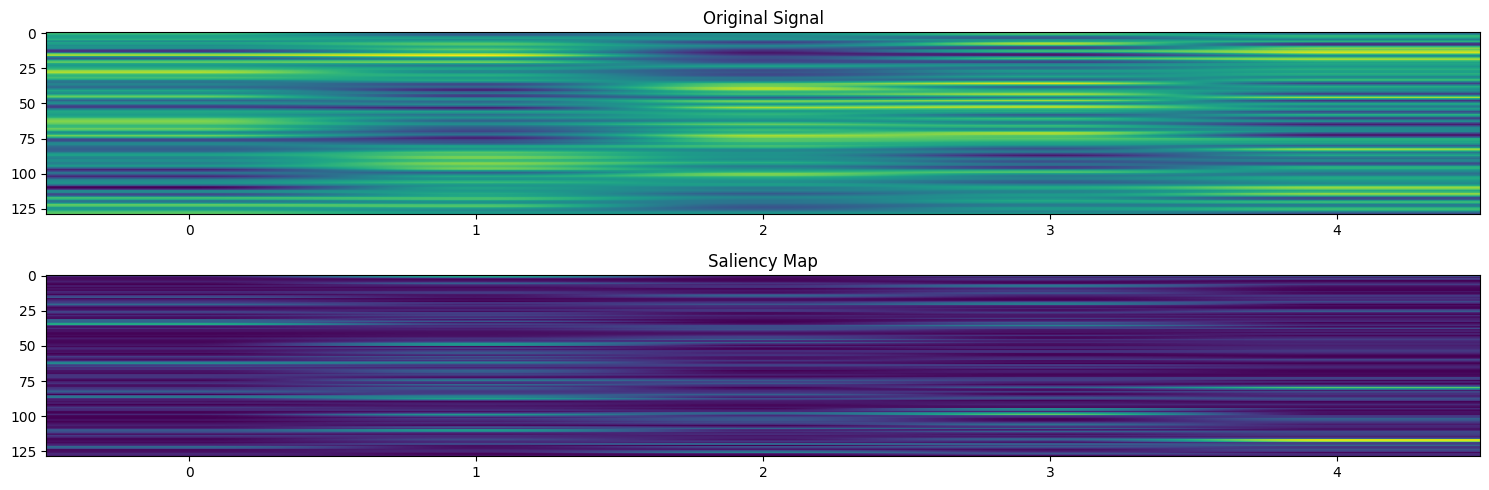

In [39]:
def compute_saliency(model, input_data, target_class):
    input_tensor = tf.convert_to_tensor(input_data)
    
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        predictions = model(input_tensor)
        loss = predictions[:, target_class]
    
    gradients = tape.gradient(loss, input_tensor)
    return gradients.numpy()

sample_idx = 0
true_class = np.argmax(y_test[sample_idx])
saliency = compute_saliency(cnn_model, X_test[sample_idx:sample_idx+1], true_class)

plt.figure(figsize=(15, 5))
plt.subplot(2, 1, 1)
plt.imshow(X_test[sample_idx, :, :, 0].T, aspect='auto')
plt.title('Original Signal')
plt.subplot(2, 1, 2)
plt.imshow(np.abs(saliency[0, :, :, 0]).T, aspect='auto')
plt.title('Saliency Map')
plt.tight_layout()
plt.show()

408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


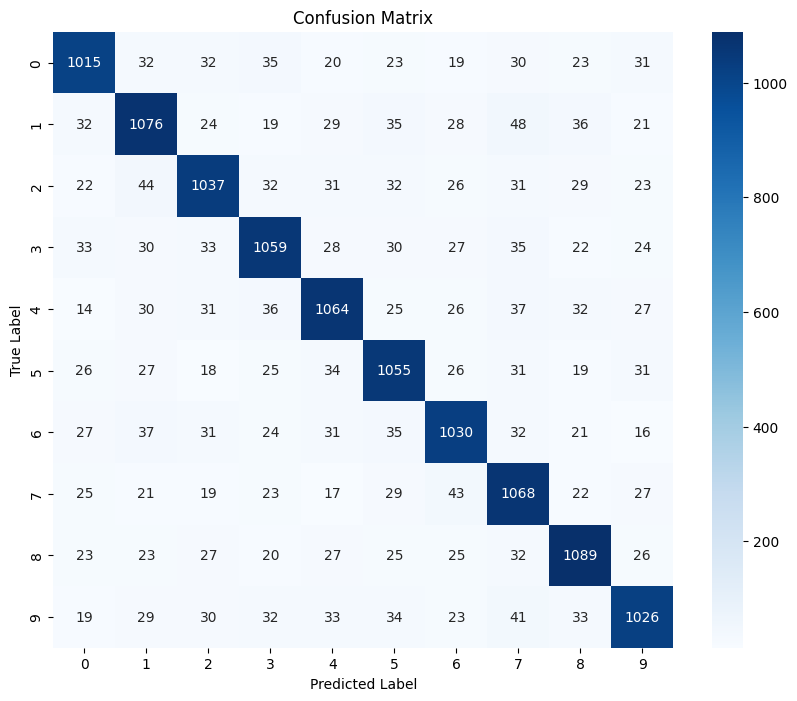

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

              precision    recall  f1-score   support

           0       0.82      0.81      0.81      1260
           1       0.80      0.80      0.80      1348
           2       0.81      0.79      0.80      1307
           3       0.81      0.80      0.81      1321
           4       0.81      0.80      0.81      1322
           5       0.80      0.82      0.81      1292
           6       0.81      0.80      0.81      1284
           7       0.77      0.83      0.80      1294
           8       0.82      0.83      0.82      1317
           9       0.82      0.79      0.80      1300

    accuracy                           0.81     13045
   macro avg       0.81      0.81      0.81     13045
weighted avg       0.81      0.81      0.81     13045



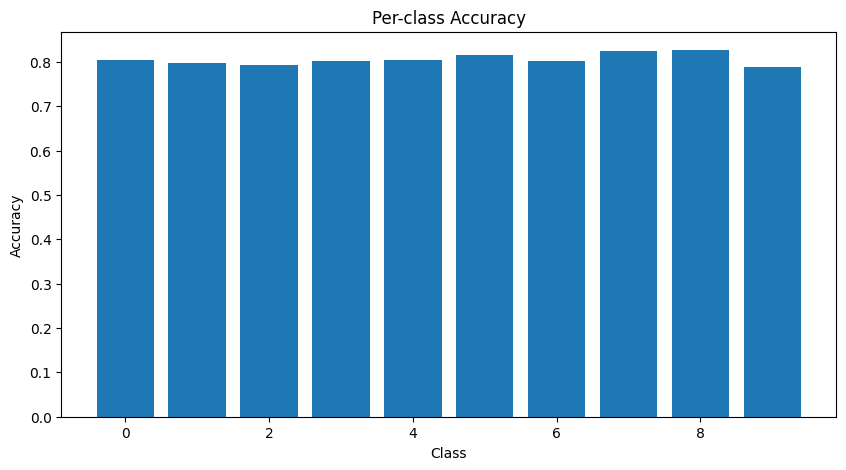

In [42]:
from sklearn.metrics import classification_report

print(classification_report(y_true_classes, y_pred_classes))

class_accuracy = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(10, 5))
plt.bar(range(10), class_accuracy)
plt.title('Per-class Accuracy')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.show()